/media/racah/2b2b05ab-497e-47ab-a698-6e77a3b775c4/grisha/for_ProtLigMap/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/media/racah/2b2b05ab-497e-47ab-a698-6e77a3b775c4/grisha/for_ProtLigMap/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


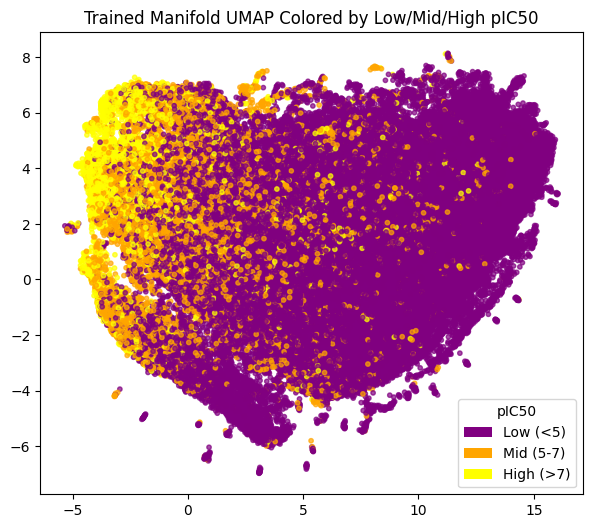

In [ ]:
%matplotlib inline
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
import os
import numpy as np
import torch
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch
from src.utils.model_utils.initialise import ProteinLigandDataset

# === Paths ===
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
proj_path = os.path.join(project_root, "results/manifold_model/full_manifold/projection_embeddings.pt")
data_path = os.path.join(project_root, "outputs/datasets.pt")

# === Load embeddings and dataset ===
proj_emb = torch.load(proj_path, map_location="cpu")
all_data = torch.load(data_path, weights_only=False)

# === UMAP projection ===
umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.5, n_components=2, random_state=42).fit_transform(proj_emb)

# === Extract pIC50 values ===
pic50_raw_values = np.concatenate([all_data[split].pic50_raw.numpy() for split in ["train", "val"]])

# === Bin pIC50 values ===
bins = [pic50_raw_values.min() - 1e-8, 5, 7, pic50_raw_values.max() + 1e-8]
pic50_categories = np.clip(np.digitize(pic50_raw_values, bins) - 1, 0, 2)
colors = np.array(["purple", "orange", "yellow"])
pic50_point_colors = colors[pic50_categories]

# === Plot ===
plt.figure(figsize=(7,6))
plt.scatter(umap_emb[:,0], umap_emb[:,1], c=pic50_point_colors, s=10, alpha=0.7)
legend_elements = [
    Patch(facecolor="purple", label="Low (<5)"),
    Patch(facecolor="orange", label="Mid (5-7)"),
    Patch(facecolor="yellow", label="High (>7)")
]
plt.legend(handles=legend_elements, title="pIC50")
plt.title("Trained Manifold UMAP Colored by Low/Mid/High pIC50")
plt.show()


/media/racah/2b2b05ab-497e-47ab-a698-6e77a3b775c4/grisha/for_ProtLigMap/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


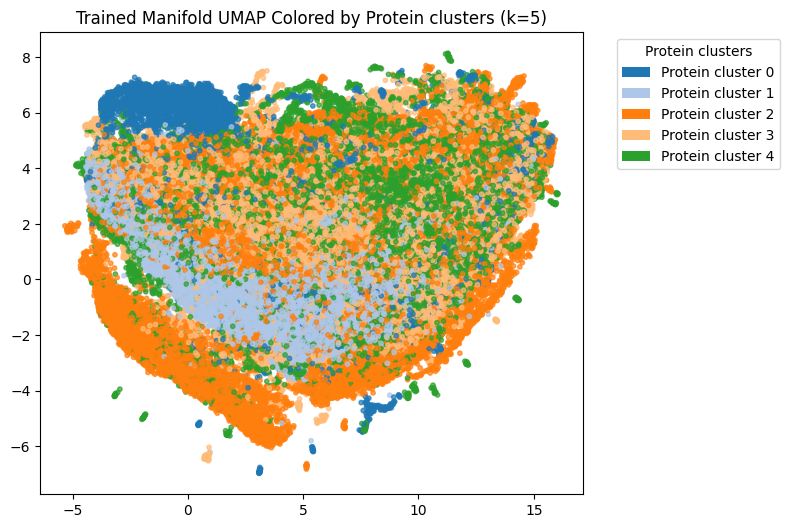

In [ ]:
%matplotlib inline
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
import os
import numpy as np
import torch
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from src.utils.model_utils.initialise import ProteinLigandDataset

# === Paths ===
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
proj_path = os.path.join(project_root, "results/manifold_model/full_manifold/projection_embeddings.pt")
data_path = os.path.join(project_root, "outputs/datasets.pt")

# === Load embeddings and dataset ===
proj_emb = torch.load(proj_path, map_location="cpu")
all_data = torch.load(data_path, weights_only=False)

# === UMAP projection ===
umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.5, n_components=2, random_state=42).fit_transform(proj_emb)

# === Extract protein indices in same order ===
prot_idx_values = np.concatenate([all_data[split].prot_idx.numpy() for split in ["train", "val"]])

# Optional: if you want to cluster proteins into e.g., 5 groups
n_prot_clusters = 5
# Use PCA + normalize on protein vectors for clustering (like in plotting.py)
all_prots_train = all_data["train"].prot_raw_agg_filtered_into_model
prot_std = StandardScaler().fit_transform(all_prots_train)
prot_pca = PCA(n_components=0.95).fit_transform(prot_std)
prot_proc = normalize(prot_pca, norm='l2')

# Cluster proteins
kmeans = KMeans(n_clusters=n_prot_clusters, random_state=42)
prot_cluster_labels_train = kmeans.fit_predict(prot_proc)

# Map cluster labels to train + val
prot_cluster_labels = np.array([prot_cluster_labels_train[idx] for idx in prot_idx_values])

# === Map cluster labels to colors ===
cmap = plt.get_cmap('tab20')  # tab20 has 20 distinct colors
n_classes = len(np.unique(prot_cluster_labels))
prot_point_colors = cmap(prot_cluster_labels % cmap.N)

# === Plot ===
plt.figure(figsize=(7,6))
plt.scatter(umap_emb[:,0], umap_emb[:,1], c=prot_point_colors, s=10, alpha=0.7)

# Create legend
legend_elements = [Patch(facecolor=cmap(i % cmap.N), label=f"Protein cluster {i}") 
                   for i in range(n_classes)]
plt.legend(handles=legend_elements, title="Protein clusters", bbox_to_anchor=(1.05,1), loc='upper left')
plt.title(f"Trained Manifold UMAP Colored by Protein clusters (k={n_prot_clusters})")
plt.show()


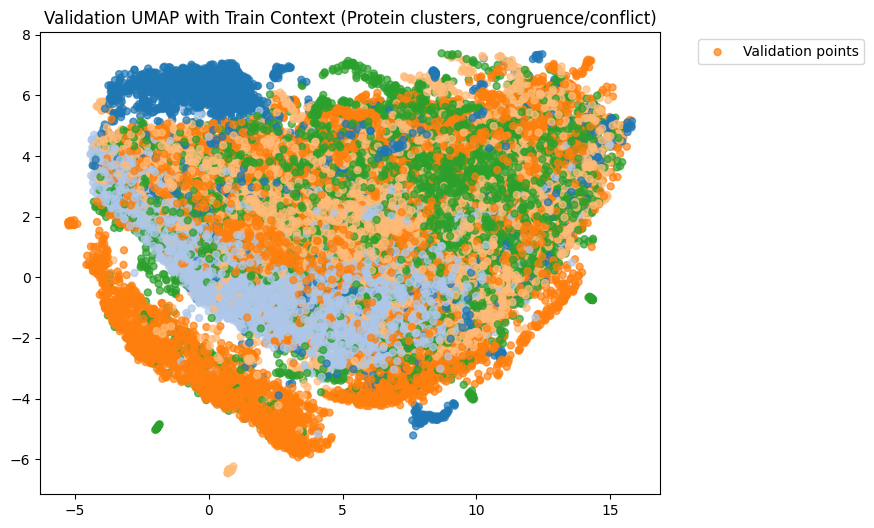

In [4]:
from sklearn.neighbors import NearestNeighbors

# === Split train / val ===
n_train = len(all_data["train"])
train_umap = umap_emb[:n_train]
val_umap = umap_emb[n_train:]

train_labels = prot_cluster_labels[:n_train]
val_labels = prot_cluster_labels[n_train:]

# Original val cluster colors
val_cluster_colors = prot_point_colors[n_train:]

# Parameters
radius = 0.5  # adjust depending on UMAP scale

# Fit NearestNeighbors on train
nn = NearestNeighbors(radius=radius)
nn.fit(train_umap)

# Find neighbors for each val point
neighbors_list = nn.radius_neighbors(val_umap, return_distance=False)

# Create masks
congruent_mask = np.zeros(len(val_labels), dtype=bool)
conflict_mask   = np.zeros(len(val_labels), dtype=bool)
isolated_mask   = np.zeros(len(val_labels), dtype=bool)

for i, neighbors in enumerate(neighbors_list):
    if len(neighbors) == 0:
        isolated_mask[i] = True
    elif any(train_labels[idx] == val_labels[i] for idx in neighbors):
        congruent_mask[i] = True
    else:
        conflict_mask[i] = True

# Prepare plotting
plt.figure(figsize=(8,6))

# # Plot train points as orange crosses (instead of gray circles)
# Plot validation points with their original cluster colors
plt.scatter(val_umap[:,0], val_umap[:,1], 
            c=val_cluster_colors, marker='o', s=25, alpha=0.7, label='Validation points')


# # Plot congruent val points with black cross, half transparent
# plt.scatter(val_umap[congruent_mask,0], val_umap[congruent_mask,1], 
#             c='black', marker='x', s=25, alpha=0.05, label='Val congruent')

# # Plot conflict points in red cross, half transparent
# plt.scatter(val_umap[conflict_mask,0], val_umap[conflict_mask,1], 
#             c='red', marker='x', s=25, alpha=0.9, label='Val conflict')


# # Plot isolated points in purple cross
# plt.scatter(val_umap[isolated_mask,0], val_umap[isolated_mask,1], 
#             c='purple', marker='x', s=25, alpha=0.9, label='Val isolated')

plt.title("Validation UMAP with Train Context (Protein clusters, congruence/conflict)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()



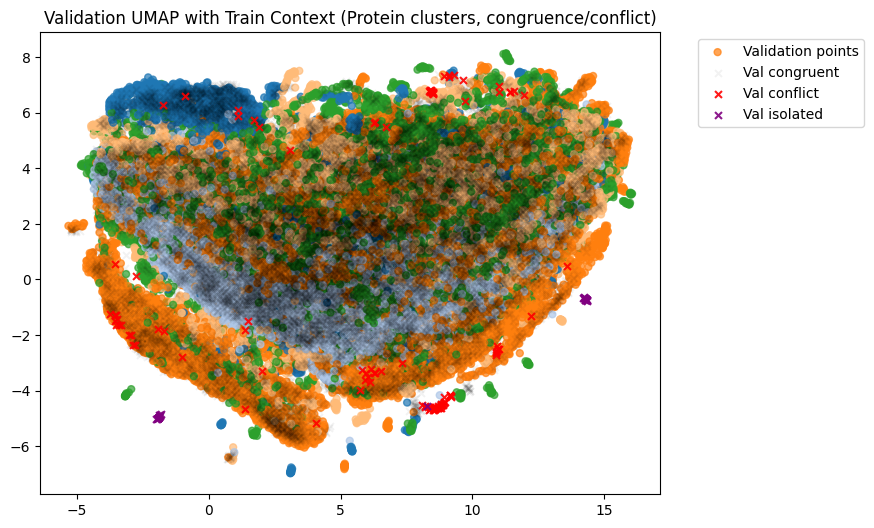

In [5]:
train_cluster_colors = prot_point_colors[:n_train]


# Prepare plotting
plt.figure(figsize=(8,6))

# # Plot train points as orange crosses (instead of gray circles)
# Plot validation points with their original cluster colors
plt.scatter(train_umap[:,0], train_umap[:,1], 
            c=train_cluster_colors, marker='o', s=25, alpha=0.7, label='Validation points')


# Plot congruent val points with black cross, half transparent
plt.scatter(val_umap[congruent_mask,0], val_umap[congruent_mask,1], 
            c='black', marker='x', s=25, alpha=0.05, label='Val congruent')

# Plot conflict points in red cross, half transparent
plt.scatter(val_umap[conflict_mask,0], val_umap[conflict_mask,1], 
            c='red', marker='x', s=25, alpha=0.9, label='Val conflict')


# Plot isolated points in purple cross
plt.scatter(val_umap[isolated_mask,0], val_umap[isolated_mask,1], 
            c='purple', marker='x', s=25, alpha=0.9, label='Val isolated')

plt.title("Validation UMAP with Train Context (Protein clusters, congruence/conflict)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()




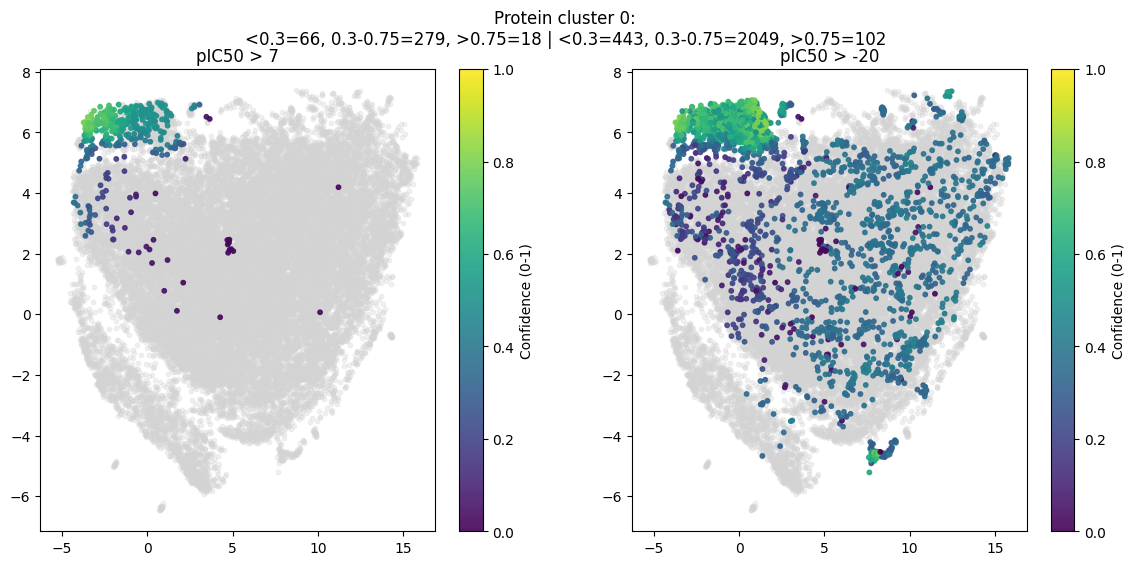

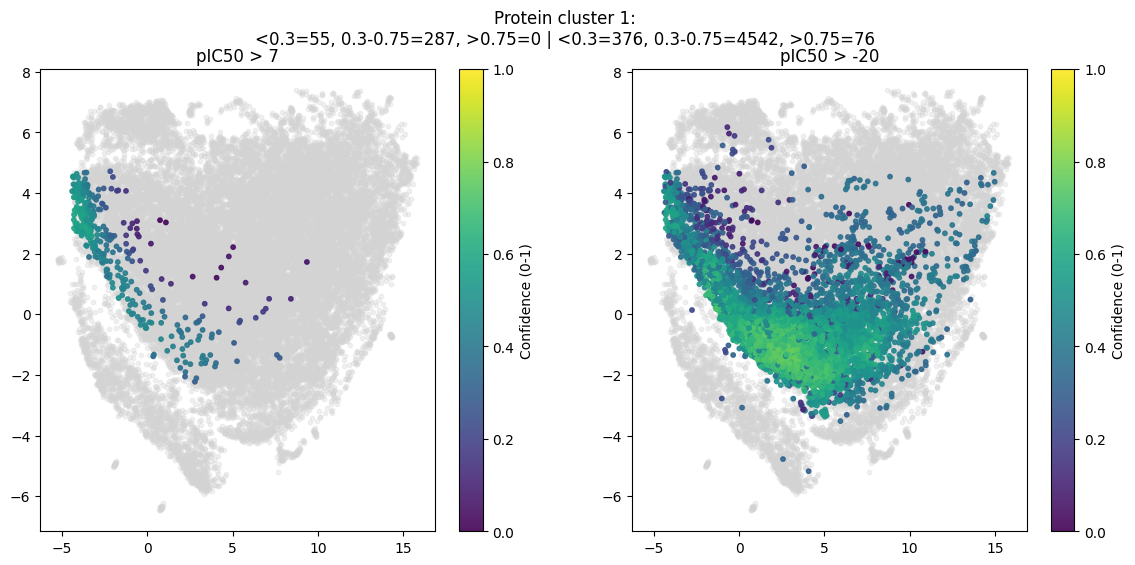

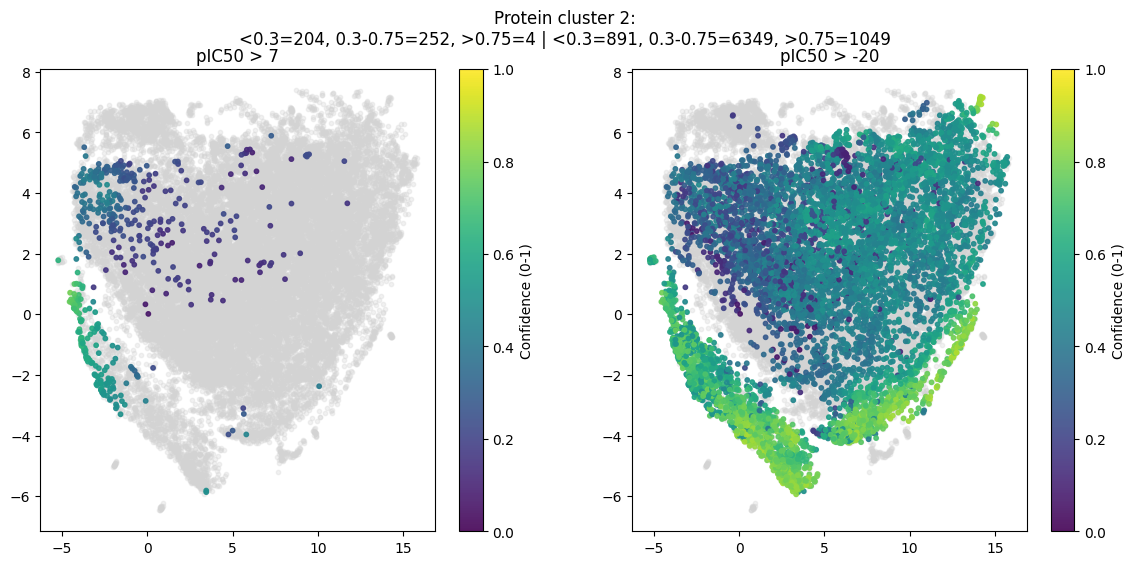

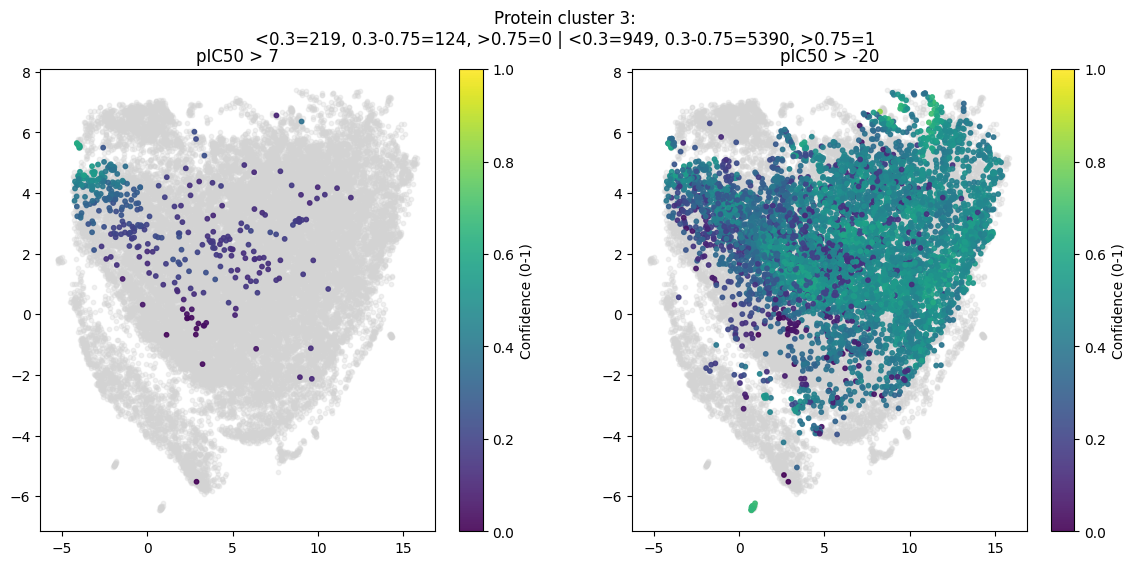

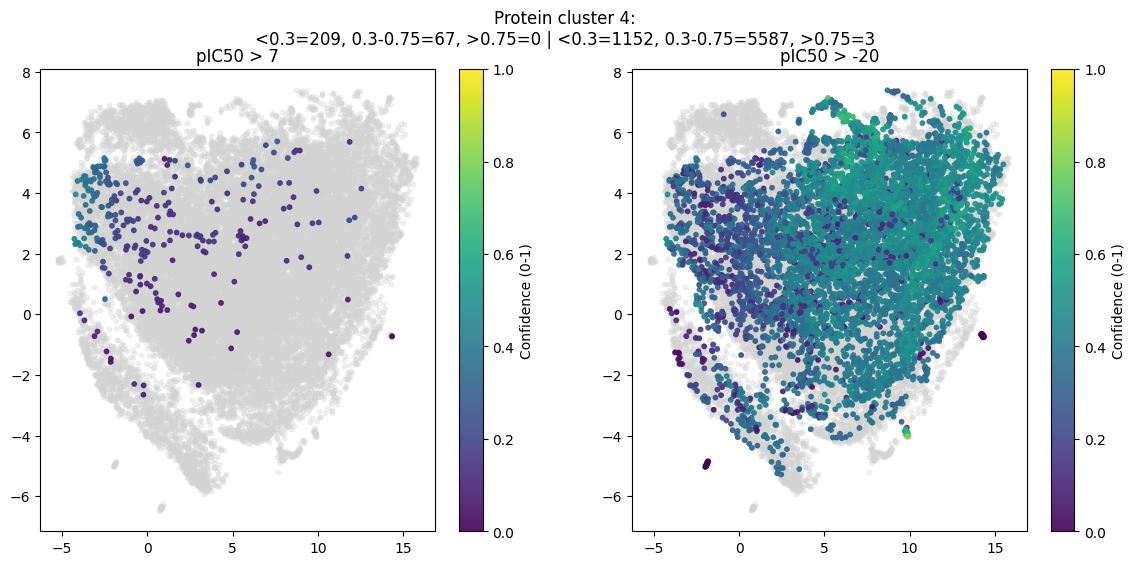

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def split_train_val(umap_emb, labels, pic50_raw_values, n_train):
    train_umap = umap_emb[:n_train]
    val_umap   = umap_emb[n_train:]
    train_labels = labels[:n_train]
    val_labels   = labels[n_train:]
    pic50_train  = pic50_raw_values[:n_train]
    pic50_val    = pic50_raw_values[n_train:]
    return train_umap, val_umap, train_labels, val_labels, pic50_train, pic50_val

def compute_confidence_fractional(coords, labels, pic50_vals, train_umap, train_labels, pic50_train, nn,
                                  w_prot=0.5, w_bin=0.3, w_close=0.2, bins=None, delta=0.5):
    """
    Confidence = weighted combination of:
      - protein cluster agreement (f_prot)
      - pIC50 bin agreement (f_bin)
      - closeness in raw pIC50 values (f_close)
    """
    if bins is None:
        raise ValueError("Please provide bins for pIC50 clustering.")

    pic50_train_clusters = np.digitize(pic50_train, bins) - 1
    pic50_clusters = np.digitize(pic50_vals, bins) - 1

    confs = []
    for i, coord in enumerate(coords):
        neighbors = nn.radius_neighbors([coord], return_distance=False)[0]
        if len(neighbors) == 0:
            confs.append(0.0)
            continue

        same_prot = 0
        same_bin = 0
        close_val = 0

        for idx in neighbors:
            if train_labels[idx] == labels[i]:
                same_prot += 1
            if pic50_train_clusters[idx] == pic50_clusters[i]:
                same_bin += 1
            if abs(pic50_train[idx] - pic50_vals[i]) <= delta:
                close_val += 1

        f_prot  = same_prot / len(neighbors)
        f_bin   = same_bin / len(neighbors)
        f_close = close_val / len(neighbors)

        conf = w_prot * f_prot + w_bin * f_bin + w_close * f_close
        confs.append(conf)

    return np.array(confs)




def plot_side_by_side(val_umap, filtered_umaps, filtered_confs, prot_cluster, titles, counts_texts):
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    
    for ax, filtered_umap, conf, title in zip(axes, filtered_umaps, filtered_confs, titles):
        ax.scatter(val_umap[:,0], val_umap[:,1], c='lightgray', s=10, alpha=0.3)
        if len(filtered_umap) > 0:
            sc = ax.scatter(filtered_umap[:,0], filtered_umap[:,1], 
                            c=conf, cmap='viridis', s=10, alpha=0.9, vmin=0, vmax=1)
            plt.colorbar(sc, ax=ax, label='Confidence (0-1)')
        ax.set_title(title)
    
    # Set a super title with counts above the two plots
    fig.suptitle(f"Protein cluster {prot_cluster}:\n{counts_texts[0]} | {counts_texts[1]}", fontsize=12)
    plt.show()

# === Main ===
n_train = len(all_data["train"])
train_umap, val_umap, train_labels, val_labels, pic50_train, pic50_val = split_train_val(
    umap_emb, prot_cluster_labels, pic50_raw_values, n_train
)

radius = 0.5
alpha_neg = 2.0
nn = NearestNeighbors(radius=radius)
nn.fit(train_umap)

n_prot_clusters = 5
thresholds = [7, -20]
titles = ["pIC50 > 7", "pIC50 > -20"]

for prot_cluster in range(n_prot_clusters):
    protein_mask = val_labels == prot_cluster
    
    filtered_umaps = []
    filtered_confs = []
    counts_texts = []
    
    for pic50_threshold in thresholds:
        filtered_mask = protein_mask & (pic50_val > pic50_threshold)
        filtered_val_umap = val_umap[filtered_mask]
        filtered_val_labels = val_labels[filtered_mask]
        filtered_val_pic50 = pic50_val[filtered_mask]
        
        if len(filtered_val_umap) == 0:
            filtered_umaps.append(np.array([]))
            filtered_confs.append(np.array([]))
            counts_texts.append("<0.3=0, 0.3-0.75=0, >0.75=0")
            continue
        
        bins = [pic50_raw_values.min() - 1e-8, 5, 7, pic50_raw_values.max() + 1e-8]

        conf = compute_confidence_fractional(
            filtered_val_umap,
            filtered_val_labels,
            filtered_val_pic50,
            train_umap,
            train_labels,
            pic50_train,
            nn,
            w_prot=0.5, w_bin=0.3, w_close=0.2,
            bins=bins,
            delta=0.5
        )




        filtered_umaps.append(filtered_val_umap)
        filtered_confs.append(conf)
        
        # Compute counts for this threshold
        n_low  = np.sum(conf < 0.3)
        n_mid  = np.sum((conf >= 0.3) & (conf <= 0.75))
        n_high = np.sum(conf > 0.75)
        counts_texts.append(f"<0.3={n_low}, 0.3-0.75={n_mid}, >0.75={n_high}")
    
    plot_side_by_side(val_umap, filtered_umaps, filtered_confs, prot_cluster, titles, counts_texts)


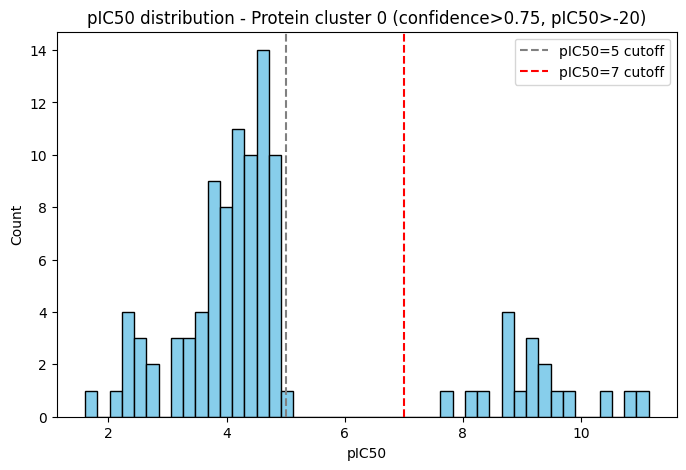

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# === Filter points for protein cluster 0 ===
prot_cluster = 0
protein_mask = val_labels == prot_cluster
pic50_threshold = -20
conf_threshold = 0.75

filtered_mask = protein_mask & (pic50_val > pic50_threshold)
filtered_val_umap = val_umap[filtered_mask]
filtered_val_labels = val_labels[filtered_mask]
filtered_val_pic50 = pic50_val[filtered_mask]

# Compute confidence
bins = [pic50_raw_values.min() - 1e-8, 5, 7, pic50_raw_values.max() + 1e-8]

conf = compute_confidence_fractional(
    filtered_val_umap,
    filtered_val_labels,
    filtered_val_pic50,
    train_umap,
    train_labels,
    pic50_train,
    nn,
    w_prot=0.5, w_bin=0.3, w_close=0.2,
    bins=bins,
    delta=0.5
)

# Filter by confidence > 0.75
high_conf_mask = conf > conf_threshold
high_conf_pic50 = filtered_val_pic50[high_conf_mask]

# === Custom binning: matching widths ===
low_region = high_conf_pic50[high_conf_pic50 <= 7]
high_region = high_conf_pic50[high_conf_pic50 > 7]

if len(high_region) > 0:
    # Split >7 region into 20 equal bins
    high_bins = np.linspace(7, high_region.max() + 1e-8, 21)  
    bin_width = high_bins[1] - high_bins[0]

    # Extend below 7 using the same bin width
    low_min = low_region.min() if len(low_region) > 0 else 5
    num_low_bins = int(np.ceil((7 - low_min) / bin_width))
    low_bins = np.linspace(7 - num_low_bins * bin_width, 7, num_low_bins + 1)

    # Merge both
    bin_edges = np.unique(np.concatenate([low_bins, high_bins]))
else:
    # Fallback if no >7 values
    bin_edges = np.linspace(high_conf_pic50.min(), high_conf_pic50.max(), 20)

# Plot
plt.figure(figsize=(8,5))
plt.hist(high_conf_pic50, bins=bin_edges, color='skyblue', edgecolor='black')
plt.axvline(5, color='gray', linestyle='--', label='pIC50=5 cutoff')
plt.axvline(7, color='red', linestyle='--', label='pIC50=7 cutoff')

plt.title(f"pIC50 distribution - Protein cluster {prot_cluster} (confidence>0.75, pIC50>-20)")
plt.xlabel("pIC50")
plt.ylabel("Count")
plt.legend()
plt.show()


In [8]:
low_counts = (high_conf_pic50 <= 7).sum()
high_counts = (high_conf_pic50 > 7).sum()
print(f"Counts ratio (<=7 vs >7): {low_counts}:{high_counts}")


Counts ratio (<=7 vs >7): 84:18


In [9]:
import numpy as np

# === Parameters ===
target_cluster = 0
pic50_cutoff = 7.0
conf_cutoff = 0.75

# Step 1: mask validation data by cluster and pIC50 > 7
mask = (val_labels == target_cluster) & (pic50_val > pic50_cutoff)

filtered_val_umap = val_umap[mask]
filtered_val_labels = val_labels[mask]
filtered_val_pic50 = pic50_val[mask]
filtered_val_prot_idx = prot_idx_values[n_train:][mask]   # protein indices for val set

# Step 2: compute confidence for these filtered points
bins = [pic50_raw_values.min() - 1e-8, 5, 7, pic50_raw_values.max() + 1e-8]
conf = compute_confidence_fractional(
    filtered_val_umap,
    filtered_val_labels,
    filtered_val_pic50,
    train_umap,
    train_labels,
    pic50_train,
    nn,
    w_prot=0.5, w_bin=0.3, w_close=0.2,
    bins=bins,
    delta=0.5
)

# Step 3: apply confidence filter
high_conf_mask = conf > conf_cutoff
high_conf_prot_idx = filtered_val_prot_idx[high_conf_mask]

# Step 4: unique proteins + counts
unique_proteins, counts = np.unique(high_conf_prot_idx, return_counts=True)

print(f"Cluster {target_cluster}: {len(unique_proteins)} unique proteins with pIC50 > {pic50_cutoff} and conf > {conf_cutoff}")
for prot, count in zip(unique_proteins, counts):
    print(f"  Protein {prot}: {count} ligands")


Cluster 0: 9 unique proteins with pIC50 > 7.0 and conf > 0.75
  Protein 23: 3 ligands
  Protein 791: 1 ligands
  Protein 792: 1 ligands
  Protein 851: 2 ligands
  Protein 1557: 2 ligands
  Protein 2983: 1 ligands
  Protein 3459: 1 ligands
  Protein 3460: 3 ligands
  Protein 5074: 4 ligands


/media/racah/2b2b05ab-497e-47ab-a698-6e77a3b775c4/grisha/for_ProtLigMap/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette scores:
  k=2: 0.425
  k=3: 0.283
  k=4: 0.220
  k=5: 0.180
  k=6: 0.133
  k=7: 0.130
  k=8: 0.053
Best clustering: k=2 (silhouette=0.425)


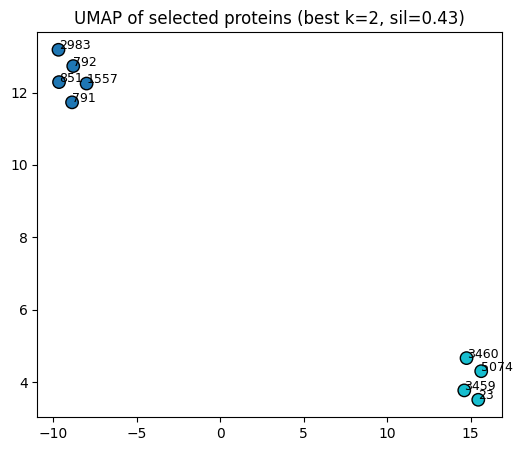

In [10]:
import numpy as np
import torch
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize

# === Step 1: get embeddings of selected proteins ===
all_prots = all_data["train"].prot_raw_agg_filtered_into_model.numpy()
selected_prot_idx = unique_proteins  # from your high-conf filtering
selected_emb = all_prots[selected_prot_idx]

# === Step 2: standardize + normalize embeddings (like before) ===
prot_std = StandardScaler().fit_transform(selected_emb)
prot_norm = normalize(prot_std, norm="l2")

# === Step 3: UMAP projection ===
umap_emb = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42).fit_transform(prot_norm)

# === Step 4: test k-means for k=2..8 ===
sil_scores = []
clusterings = {}
for k in range(2, min(8, len(selected_prot_idx)) + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(prot_norm)
    sil = silhouette_score(prot_norm, labels)
    sil_scores.append((k, sil))
    clusterings[k] = labels

# === Step 5: pick best k ===
best_k, best_sil = max(sil_scores, key=lambda x: x[1])
best_labels = clusterings[best_k]

print("Silhouette scores:")
for k, s in sil_scores:
    print(f"  k={k}: {s:.3f}")
print(f"Best clustering: k={best_k} (silhouette={best_sil:.3f})")

# === Step 6: plot UMAP with best clustering ===
plt.figure(figsize=(6,5))
plt.scatter(umap_emb[:,0], umap_emb[:,1], c=best_labels, cmap="tab10", s=80, edgecolor="k")
for i, prot in enumerate(selected_prot_idx):
    plt.text(umap_emb[i,0]+0.01, umap_emb[i,1]+0.01, str(prot), fontsize=9)
plt.title(f"UMAP of selected proteins (best k={best_k}, sil={best_sil:.2f})")
plt.show()


In [11]:
# proj_emb is full dataset (97247, D)
proj_emb = torch.load(proj_path, map_location="cpu")
proj_emb = proj_emb.numpy() if isinstance(proj_emb, torch.Tensor) else proj_emb

# Slice proj_emb to validation set only (align sizes)
proj_val = proj_emb[n_train:][mask]   # <- same slice you used to get filtered_val_prot_idx
print(f"proj_val shape: {proj_val.shape}, should match {filtered_val_prot_idx.shape[0]}")

# Now apply mask for protein 5074
protein_id = 5074
mask_5074 = (filtered_val_prot_idx == protein_id) & (conf > conf_cutoff)

points_5074 = proj_val[mask_5074]

print(f"Protein {protein_id} has {len(points_5074)} selected points in embedding space.")

if len(points_5074) > 0:
    center_5074 = points_5074.mean(axis=0)
    print(f"Center coordinate for Protein {protein_id}: {center_5074}")
else:
    center_5074 = None
    print(f"No points found for Protein {protein_id} with conf > {conf_cutoff}")


proj_val shape: (363, 64), should match 363
Protein 5074 has 4 selected points in embedding space.
Center coordinate for Protein 5074: [-0.20943701 -0.02706268 -0.22861734  0.04922063 -0.23504798  0.16449662
 -0.02769492  0.14428979 -0.09258841  0.08853168  0.03468495 -0.11383407
  0.02342255  0.31596282  0.15645035 -0.01674963 -0.03916114  0.07851347
 -0.05960339  0.10628544  0.05042715 -0.07671475  0.09563485 -0.13355406
  0.14645186  0.27190447 -0.14819399 -0.08485777 -0.03854924  0.14312635
  0.14007303 -0.12441251  0.06106166 -0.08467911  0.0788693   0.02628414
  0.13281853 -0.19261967 -0.13294989 -0.16452536 -0.03942445 -0.03281821
 -0.11687515 -0.2534145   0.09643812 -0.02112324  0.0761862  -0.20119283
  0.0520008  -0.04430271 -0.03926907  0.12178623  0.1329781   0.06466655
  0.02304464  0.09400624 -0.12035516  0.04061312  0.04313935 -0.07953584
  0.09129781  0.20671898  0.00298296 -0.11549029]


In [12]:
# Step 1: indices of validation set
val_indices = np.arange(len(filtered_val_prot_idx))  # 0..362 for 363 filtered points

# Step 2: high confidence + protein mask
protein_id = 5074
high_conf_mask = (conf > conf_cutoff)
protein_mask = (filtered_val_prot_idx == protein_id)
final_mask = protein_mask & high_conf_mask

# Step 3: get the indices of filtered_val_prot_idx that match
selected_indices = val_indices[final_mask]  # indices into filtered_val_prot_idx

# Step 4: map back to the original valid_keys in validation set
# We need the corresponding original indices of the validation set:
# Suppose filtered_val_prot_idx comes from mask applied on all_data["val"]
# If you still have that original mask used to generate filtered_val_prot_idx, you can do:
original_val_mask = (val_labels == target_cluster) & (pic50_val > pic50_cutoff)
keys_5074 = all_data["val"].valid_keys[original_val_mask][selected_indices]

print(f"Protein {protein_id} has {len(keys_5074)} valid keys")
print(keys_5074)


Protein 5074 has 4 valid keys
['6dh0_pose1' '6dh1_pose5' '6dh2_pose2' '6dh2_pose8']


In [ ]:
# !git clone https://github.com/hasanulmukit/smiles2dta-demo.git
# !cd smiles2dta-demo
# !pip install -r requirements.txt
# !streamlit run smiles2dta_app.py

In [ ]:
import os
import pickle
import numpy as np
import selfies as sf
import torch
import torch.nn as nn
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import logging

# ---------------- Paths ----------------
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
output_path = os.path.join(project_root, "outputs/ligand_model_training")
model_path = os.path.join(output_path, "ligand_transformer_epoch5_batch20.pt")
scaler_pca_path = os.path.join(output_path, "scaler_pca.pkl")

# ---------------- Logging setup ----------------
log_file = os.path.join(output_path, "generation_log.txt")
record_file = os.path.join(output_path, "record_pic50_log.txt")
os.makedirs(output_path, exist_ok=True)

# Configure main logger
logging.basicConfig(
    level=logging.INFO,
    format='%(message)s',
    handlers=[
        logging.FileHandler(log_file, mode='w'),
        logging.StreamHandler()
    ]
)

# Initialize record log if not exists
if not os.path.exists(record_file):
    with open(record_file, 'w') as f:
        f.write("Highest pIC50 molecules:\n")

# ---------------- Load PCA & Scaler ----------------
with open(scaler_pca_path, 'rb') as f:
    scaler, pca_X = pickle.load(f)

# ---------------- Ligand Transformer ----------------
class LigandTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, vocab_size, max_len, pad_idx, nhead=8, num_layers=3):
        super().__init__()
        self.max_len = max_len
        self.pad_idx = pad_idx
        self.hidden_dim = hidden_dim
        self.token_embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=pad_idx)
        self.pos_embedding = nn.Embedding(max_len, hidden_dim)
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, y=None, temperature=1.0):
        device = x.device
        batch_size = x.size(0)
        memory = self.input_fc(x).unsqueeze(0)
        if y is not None:
            tgt_emb = self.token_embedding(y)
            seq_len = y.size(1)
            positions = torch.arange(seq_len, device=device).unsqueeze(0).repeat(batch_size, 1)
            tgt = (tgt_emb + self.pos_embedding(positions)).transpose(0, 1)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(device)
            out = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask)
            return self.fc_out(out.transpose(0, 1))
        else:
            input_token = torch.full((batch_size,), self.pad_idx, dtype=torch.long, device=device)
            outputs = []
            for t in range(self.max_len):
                token_emb = self.token_embedding(input_token)
                pos_emb = self.pos_embedding(torch.tensor([t], device=device)).expand(batch_size, -1)
                tgt = (token_emb + pos_emb).unsqueeze(0)
                out = self.transformer_decoder(tgt, memory)
                logits = self.fc_out(out.squeeze(0))
                probs = torch.softmax(logits / temperature, dim=-1)
                input_token = torch.multinomial(probs, num_samples=1).squeeze(-1)
                outputs.append(input_token)
            return torch.stack(outputs, dim=1)

# ---------------- Alphabet & Dict ----------------
ALPHABET = [
    '[C]', '[O]', '[N]', '[=C]', '[=O]', '[=N]', '[#C]', '[#N]',
    '[Branch1_1]', '[Branch1_2]', '[Ring1]', '[Ring2]',
    '[F]', '[Cl]', '[Br]', '[I]', '[S]', '[=S]', '[P]', '[=P]',
    '[C@@H]', '[C@H]', '[C@@]', '[C@]'
]
VOCAB_DICT = {tok: i + 1 for i, tok in enumerate(ALPHABET)}
VOCAB_SIZE = len(ALPHABET) + 1
PAD_IDX = 0
MAX_LEN = 100
idx_to_token = {i: tok for tok, i in VOCAB_DICT.items()}

# ---------------- Load Ligand Transformer ----------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LigandTransformer(input_dim=pca_X.n_components_, hidden_dim=256,
                          vocab_size=VOCAB_SIZE, max_len=MAX_LEN, pad_idx=PAD_IDX).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ---------------- Generate SMILES ----------------
def cleanup_selfies(selfies_tokens, max_repeats=3):
    cleaned_tokens = []
    prev_token = None
    repeat_count = 0
    for tok in selfies_tokens:
        if tok == prev_token:
            repeat_count += 1
            if repeat_count <= max_repeats:
                cleaned_tokens.append(tok)
        else:
            repeat_count = 1
            cleaned_tokens.append(tok)
            prev_token = tok
    while cleaned_tokens and cleaned_tokens[0] in [')', '(']:
        cleaned_tokens.pop(0)
    while cleaned_tokens and cleaned_tokens[-1] in [')', '(']:
        cleaned_tokens.pop(-1)
    return cleaned_tokens

def generate_valid_smiles(model, input_tensor, idx_to_token, max_attempts=200, temperature=1.3, k=10):
    for attempt in range(max_attempts):
        model.eval()
        batch_size = input_tensor.size(0)
        device = input_tensor.device
        input_token = torch.full((batch_size,), PAD_IDX, dtype=torch.long, device=device)
        outputs = []
        memory = model.input_fc(input_tensor).unsqueeze(0)
        for t in range(MAX_LEN):
            token_emb = model.token_embedding(input_token)
            pos_emb = model.pos_embedding(torch.tensor([t], device=device)).expand(batch_size, -1)
            tgt = (token_emb + pos_emb).unsqueeze(0)
            out = model.transformer_decoder(tgt, memory)
            logits = model.fc_out(out.squeeze(0))
            probs = torch.softmax(logits / temperature, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, k, dim=-1)
            topk_probs = topk_probs / topk_probs.sum(dim=-1, keepdim=True)
            input_token = topk_indices.gather(-1, torch.multinomial(topk_probs, 1)).squeeze(-1)
            outputs.append(input_token)
        token_indices = torch.stack(outputs, dim=1).cpu().numpy()[0]
        selfies_tokens = [idx_to_token[i] for i in token_indices if i in idx_to_token]
        selfies_tokens = cleanup_selfies(selfies_tokens, max_repeats=2)
        selfies_str = ''.join(selfies_tokens)
        selfies_str = selfies_str.replace('))','').replace('((','')
        try:
            smiles = sf.decoder(selfies_str)
            if smiles:
                return selfies_str, smiles
        except:
            continue
    return selfies_str, None

# ---------------- SMILES2DTA Model ----------------
model_s2d_path = "smiles2dta_demo/mDTBA_v1dtc.h5"
s2d_model = load_model(model_s2d_path, compile=False)

SMILES2DTA_LIGAND_LEN = 85
SMILES2DTA_PROTEIN_LEN = 1200

def protein_to_seq(protein_str):
    aa_dict = {aa: i+1 for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}
    seq = [aa_dict.get(aa, 0) for aa in protein_str]
    if len(seq) < SMILES2DTA_PROTEIN_LEN:
        seq += [0] * (SMILES2DTA_PROTEIN_LEN - len(seq))
    else:
        seq = seq[:SMILES2DTA_PROTEIN_LEN]
    return np.array([seq])

def smiles_to_seq(smiles):
    seq = []
    i = 0
    while i < len(smiles):
        matched = False
        for token in sorted(ALPHABET, key=lambda x: -len(x)):
            if smiles[i:i+len(token)] == token:
                seq.append(VOCAB_DICT[token])
                i += len(token)
                matched = True
                break
        if not matched:
            i += 1
    return seq

def predict_pic50(smiles, protein_str):
    seq_ligand = smiles_to_seq(smiles)
    seq_ligand_padded = pad_sequences([seq_ligand], maxlen=SMILES2DTA_LIGAND_LEN, padding='post')
    seq_protein_padded = protein_to_seq(protein_str.replace(" ", ""))
    pred = s2d_model.predict([seq_ligand_padded, seq_protein_padded], verbose=0)
    return pred[0][0]

# ---------------- Example center ----------------
center_5074 = np.random.rand(pca_X.n_features_in_)
center_scaled = scaler.transform(center_5074.reshape(1, -1))
center_pca = pca_X.transform(center_scaled)
center_tensor = torch.tensor(center_pca, dtype=torch.float32, device=device)

# ---------------- Protein sequence ----------------
protein_str = "PQITLWKRP LVTIKIGGQLKELAALDTGAADDTVLEEMNLPRGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNVIGRNLTQIGCTLNF PQITLWKRP LVTIKIGGQLKELAALDTGAADDTVLEEMNLPRGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNVIGRNLTQIGCTLNF"

# ---------------- Hyperparameter grid ----------------
temperatures = [1.0, 1.2, 1.5]
top_ks = [5, 10, 20]
max_attempts_list = [50, 100]

num_loops = 100
best_results = []
highest_pic50 = -np.inf  # track highest pIC50 so far

for loop_idx in range(num_loops):
    temperature = random.choice(temperatures)
    k = random.choice(top_ks)
    max_attempts = random.choice(max_attempts_list)

    selfies_str, smiles = generate_valid_smiles(model, center_tensor, idx_to_token,
                                                max_attempts=max_attempts, temperature=temperature, k=k)
    if smiles:
        pic50 = predict_pic50(smiles, protein_str)
        best_results.append({
            "smiles": smiles,
            "selfies": selfies_str,
            "pic50": pic50,
            "temperature": temperature,
            "k": k,
            "max_attempts": max_attempts
        })
        log_msg = f"[Loop {loop_idx+1}] SMILES: {smiles} | pIC50: {pic50:.2f} | T={temperature} | k={k}"
        logging.info(log_msg)

        # Check for new record pIC50
        if pic50 > highest_pic50:
            highest_pic50 = pic50
            with open(record_file, 'a') as f:
                f.write(log_msg + "\n")
    else:
        logging.info(f"[Loop {loop_idx+1}] Failed to generate valid SMILES")

# ---------------- Sort by predicted pIC50 ----------------
best_results_sorted = sorted(best_results, key=lambda x: x["pic50"], reverse=True)

logging.info("\nTop 10 generated molecules:")
for i, res in enumerate(best_results_sorted[:10]):
    logging.info(f"{i+1}) SMILES: {res['smiles']} | pIC50: {res['pic50']:.2f} | T={res['temperature']} | k={res['k']}")


[Loop 1] SMILES: CNCC=CCC=CNCCNC=C=NNC=CCC=NC=CCC=NCCNN1C2C1C23CC3C=CCNNCN=NNCCOCCN=CC=CC=CCNNCC | pIC50: 4.21 | T=1.2 | k=10
[Loop 2] SMILES: CNNC[C@]CN=O | pIC50: 4.21 | T=1.5 | k=20
[Loop 3] SMILES: C1=CN=CCN=C=NNC=CCNNCN[C@]CC1CN[C@][C@]CC[C@@][C@][C@]CC=N[C@]2[C@]#C2 | pIC50: 4.21 | T=1.5 | k=10
[Loop 4] SMILES: C1CN=CC=NCNC1N=CNCN2CC2CNCC[C@@]N[C@][C@][C@@]#C | pIC50: 4.21 | T=1.5 | k=10
[Loop 5] SMILES: C=CC=CNCC=C1[C@][C@]C2CNCCNCN=C1CNCC=N2 | pIC50: 4.21 | T=1.5 | k=5
[Loop 6] SMILES: C=C1CC=CCC=C[C@][C@]NCC1CC=CNN=C=CNNCCN=CNCNC2C=C2CCN3CCNCCNONC4[C@@]5C3CNCNCNCCNC5C4NCNCNCNC | pIC50: 4.21 | T=1.0 | k=20
[Loop 7] SMILES: C=CCN[C@][C@]CC=CC=CC=NCC1NCNC#CCC=CNCC1=O | pIC50: 4.21 | T=1.2 | k=10
[Loop 8] SMILES: C=CNNCC=CCC=CNC=CNCNCNC=C=CNCCNC=NC=CCNCC=CNCCN1[C@][C@]NCCN2CCNC=C1CC=CCN=C2CCCNNCN | pIC50: 4.21 | T=1.5 | k=5
[Loop 9] SMILES: C12[C@][C@]NCCNCCNNCC1NC=CNCNCC[C@][C@]=CCNN=C[C@@]=CCC2C=CNC#CCNC=CCN=O | pIC50: 4.21 | T=1.5 | k=20
[Loop 10] SMILES: C=CNCCNCCNCCNNCCN1C#CN